In [36]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.patches as patches
import cartopy.feature as cfeature

In [13]:
mon_sst_anom = xr.open_dataset('/home/k16v981/my_work/data/era5/era5_sst_month_anom.nc')

mon_sst_anom =  mon_sst_anom.sortby('valid_time')

mon_sst_anom = mon_sst_anom.rename({'valid_time': 'date'})

new_dates = pd.to_datetime(mon_sst_anom.coords['date']).to_period('M').start_time
mon_sst_anom = mon_sst_anom.assign_coords(date=new_dates)

<xarray.Dataset> Size: 4GB
Dimensions:     (valid_time: 972, latitude: 721, longitude: 1440)
Coordinates:
    number      (valid_time) int64 8kB ...
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * valid_time  (valid_time) datetime64[ns] 8kB 1940-01-31 ... 2020-12-31
    surface     (valid_time) float64 8kB ...
    month       (valid_time) int64 8kB ...
Data variables:
    sst         (valid_time, latitude, longitude) float32 4GB ...

In [14]:
abfz = mon_sst_anom['sst'].sel(
    longitude=(mon_sst_anom['sst'].longitude < 15) | (mon_sst_anom['sst'].longitude > 355),
    latitude=slice(-10, -20)  
)


print(abfz)

<xarray.DataArray 'sst' (valid_time: 972, latitude: 41, longitude: 79)> Size: 13MB
[3148308 values with dtype=float32]
Coordinates:
    number      (valid_time) int64 8kB ...
  * latitude    (latitude) float64 328B -10.0 -10.25 -10.5 ... -19.75 -20.0
  * longitude   (longitude) float64 632B 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * valid_time  (valid_time) datetime64[ns] 8kB 1940-01-31 ... 2020-12-31
    surface     (valid_time) float64 8kB ...
    month       (valid_time) int64 8kB ...


In [15]:
mon_geopot_sa = xr.open_dataset('/home/k16v981/my_work/data/era5/era5_mon_geopot_sa.nc')

mon_geopot_sa['date'] = pd.to_datetime(mon_geopot_sa['date'].values.astype(str), format='%Y%m%d')
mon_geopot_sa = mon_geopot_sa.sel(date=slice(None, '2020-12-01'))
print(mon_geopot_sa)

<xarray.Dataset> Size: 66MB
Dimensions:         (date: 972, pressure_level: 1, latitude: 141, longitude: 121)
Coordinates:
    number          int64 8B ...
  * date            (date) datetime64[ns] 8kB 1940-01-01 ... 2020-12-01
  * pressure_level  (pressure_level) float64 8B 500.0
  * latitude        (latitude) float64 1kB 0.0 -0.25 -0.5 ... -34.5 -34.75 -35.0
  * longitude       (longitude) float64 968B 10.0 10.25 10.5 ... 39.5 39.75 40.0
    expver          (date) <U4 16kB ...
Data variables:
    z               (date, pressure_level, latitude, longitude) float32 66MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-13T13:22 GRIB to CDM+CF via cfgrib-0.9.1...


In [1]:
mean_abfz = abfz.mean(dim=('latitude', 'longitude'))

NameError: name 'abfz' is not defined

In [39]:
months = [10, 11, 12, 1, 2]

max_sst_anom = abfz_array.max()
min_sst_anom = abfz_array.min()

year_max = abfz_array['date'][abfz_array == max_sst_anom].dt.year.values[0]
year_min = abfz_array['date'][abfz_array == min_sst_anom].dt.year.values[0]
print(year_max, year_min)

2019 1958


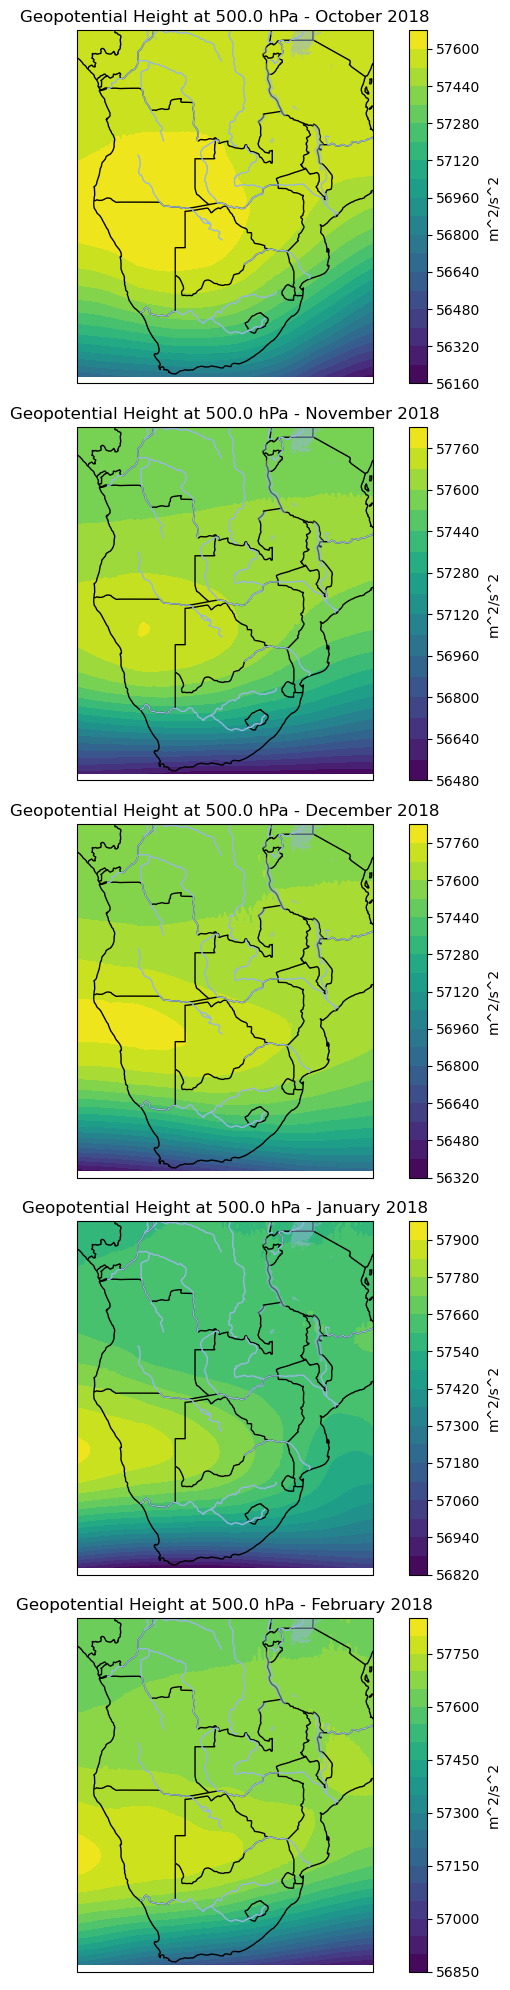

In [38]:
year_to_plot = 2018

# Filter for October to February for the specific year
filtered_data = o_f_geopot_sa.sel(date=slice(f'{year_to_plot}-10-01', f'{year_to_plot + 1}-02-01'))

# Specify the pressure level you want to plot (e.g., 500 hPa)
pressure_level = 500.0  
z_level = filtered_data.z.sel(pressure_level=pressure_level)

# Define months and their corresponding indices
months = ['October', 'November', 'December', 'January', 'February']
month_indices = [10, 11, 12, 1, 2]

# Create subplots
fig, axes = plt.subplots(len(months), 1, figsize=(10, 20), subplot_kw={'projection': ccrs.PlateCarree()})

for ax in axes:
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)
    ax.set_extent([10, 40, -35, 0])

# Loop through each month and plot
for i, month in enumerate(months):
    # Extract data for the specific month
    if i < 3:  # For October to December of the same year
        month_data = z_level.sel(date=z_level['date.month'] == month_indices[i])
    else:  # For January and February of the next year
        month_data = z_level.sel(date=z_level['date.month'] == month_indices[i])

    # Since we want data for a specific year, no need to average
    z_data = month_data.squeeze()  # This should result in 2D data (latitude, longitude)

    # Plot
    im = axes[i].contourf(month_data.longitude, month_data.latitude, z_data, 
                           levels=20, cmap='viridis', transform=ccrs.PlateCarree())
    axes[i].set_title(f'Geopotential Height at {pressure_level} hPa - {month} {year_to_plot}')
    axes[i].set_ylabel('Latitude')
    fig.colorbar(im, ax=axes[i], orientation='vertical', fraction=0.02, pad=0.04, label = 'm^2/s^2')

# Set common xlabel
plt.xlabel('Longitude')
plt.tight_layout()
plt.show()

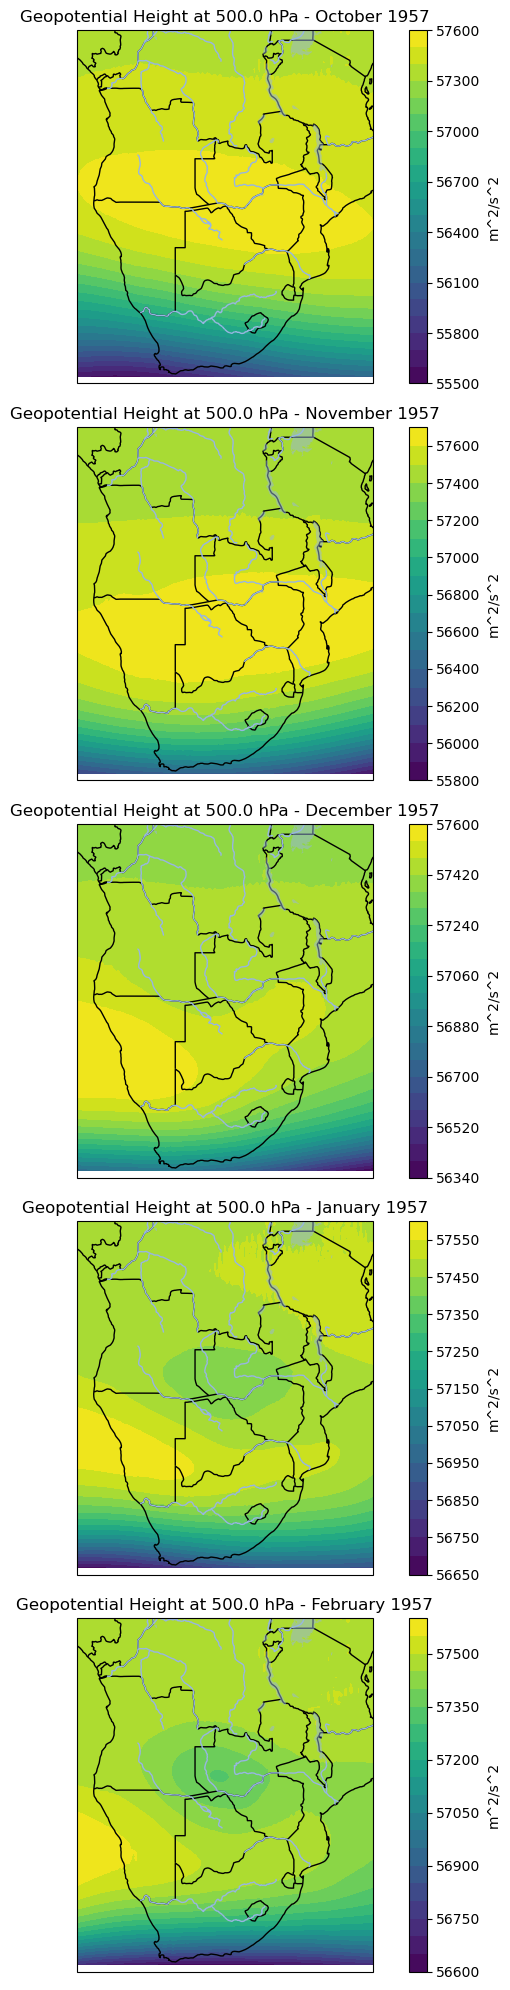

In [40]:
year_to_plot = 1957

# Filter for October to February for the specific year
filtered_data = o_f_geopot_sa.sel(date=slice(f'{year_to_plot}-10-01', f'{year_to_plot + 1}-02-01'))

# Specify the pressure level you want to plot (e.g., 500 hPa)
pressure_level = 500.0  
z_level = filtered_data.z.sel(pressure_level=pressure_level)

# Define months and their corresponding indices
months = ['October', 'November', 'December', 'January', 'February']
month_indices = [10, 11, 12, 1, 2]

# Create subplots
fig, axes = plt.subplots(len(months), 1, figsize=(10, 20), subplot_kw={'projection': ccrs.PlateCarree()})

for ax in axes:
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)
    ax.set_extent([10, 40, -35, 0])

# Loop through each month and plot
for i, month in enumerate(months):
    # Extract data for the specific month
    if i < 3:  # For October to December of the same year
        month_data = z_level.sel(date=z_level['date.month'] == month_indices[i])
    else:  # For January and February of the next year
        month_data = z_level.sel(date=z_level['date.month'] == month_indices[i])

    # Since we want data for a specific year, no need to average
    z_data = month_data.squeeze()  # This should result in 2D data (latitude, longitude)

    # Plot
    im = axes[i].contourf(month_data.longitude, month_data.latitude, z_data, 
                           levels=20, cmap='viridis', transform=ccrs.PlateCarree())
    axes[i].set_title(f'Geopotential Height at {pressure_level} hPa - {month} {year_to_plot}')
    axes[i].set_ylabel('Latitude')
    fig.colorbar(im, ax=axes[i], orientation='vertical', fraction=0.02, pad=0.04, label = 'm^2/s^2')

# Set common xlabel
plt.xlabel('Longitude')
plt.tight_layout()
plt.show()

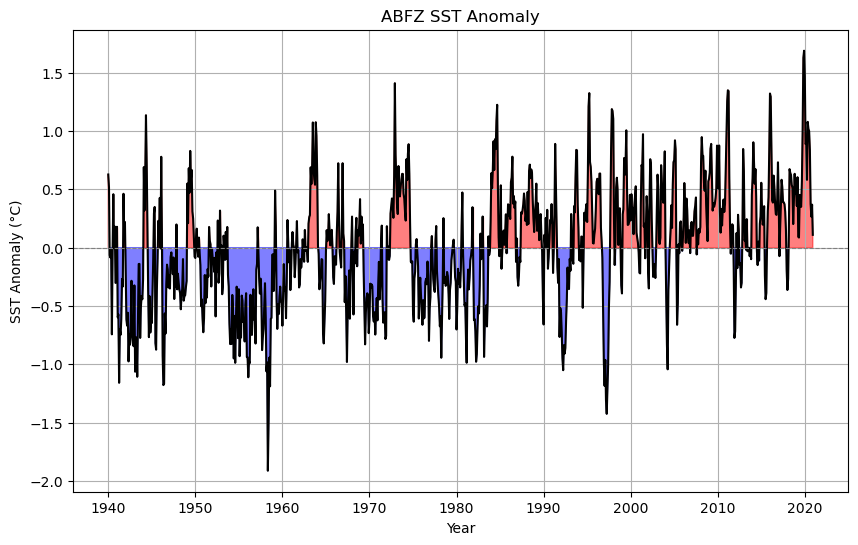

In [41]:
plt.figure(figsize=(10, 6))

# Plot the SST anomalies
plt.plot(abfz_array['date'], abfz_array, color='black')

# Fill areas above and below zero
plt.fill_between(abfz_array['date'], abfz_array, 0, where=(abfz_array > 0), color='red', alpha=0.5)
plt.fill_between(abfz_array['date'], abfz_array, 0, where=(abfz_array < 0), color='blue', alpha=0.5)

# Add labels and title
plt.axhline(0, color='gray', linewidth=0.8, linestyle='--')  # Add a horizontal line at y=0
plt.title('ABFZ SST Anomaly')
plt.xlabel('Year')
plt.ylabel('SST Anomaly (°C)')
plt.grid()

# Show the plot
plt.show()

In [42]:
mon_precip_sa = xr.open_dataset('/home/k16v981/my_work/data/era5/era5_mon_precip_sa.nc')
print(mon_precip_sa)

<xarray.Dataset> Size: 66MB
Dimensions:    (date: 972, latitude: 141, longitude: 121)
Coordinates:
    number     int64 8B ...
  * date       (date) int64 8kB 19400101 19400201 19400301 ... 20201101 20201201
  * latitude   (latitude) float64 1kB 0.0 -0.25 -0.5 ... -34.5 -34.75 -35.0
  * longitude  (longitude) float64 968B 10.0 10.25 10.5 ... 39.5 39.75 40.0
    expver     (date) <U4 16kB ...
Data variables:
    tp         (date, latitude, longitude) float32 66MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-11T20:12 GRIB to CDM+CF via cfgrib-0.9.1...


In [46]:
mon_precip_sa['date'] = pd.to_datetime(mon_precip_sa['date'].values.astype(str), format='%Y%m%d')
o_f_precip_sa = mon_precip_sa.sel(date=mon_precip_sa['date'].dt.month.isin([10, 11, 12, 1, 2]))

o_f_abfz = abfz_array.sel(date=abfz_array['date'].dt.month.isin([10, 11, 12, 1, 2]))

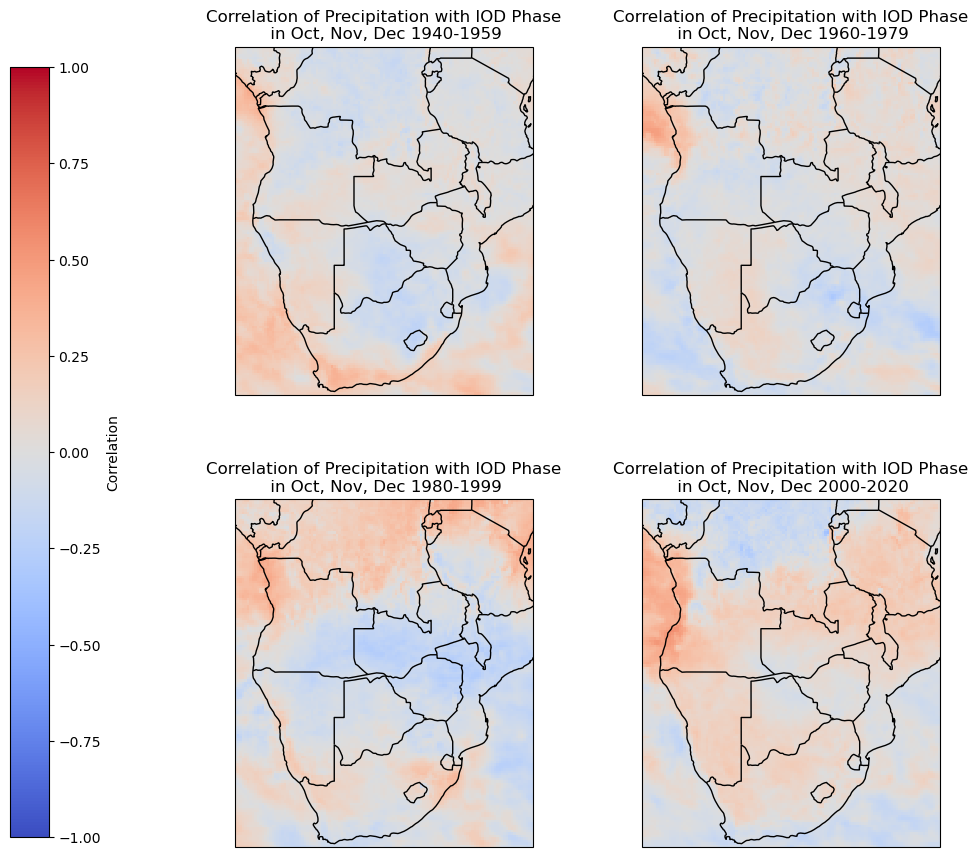

In [49]:
decades = [(1940, 1959), (1960, 1979), (1980, 1999), (2000, 2020)]
titles = ['1940-1959', '1960-1979', '1980-1999', '2000-2020']

# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()  # Flatten to easily iterate over axes

# Loop over each decade
for i, (start_year, end_year) in enumerate(decades):

    mask = (o_f_precip_sa['date'].dt.year >= start_year) & (o_f_precip_sa['date'].dt.year <= end_year)

    # Subset data for the specific decade
    ond_precip_sa_decade = o_f_precip_sa.sel(date=mask)
    ond_abfz_array_decade = o_f_abfz.sel(date=mask)
    
    # Calculate correlation
    correlation_decade = xr.corr(ond_abfz_array_decade, ond_precip_sa_decade['tp'], dim='date')
    
    # Plot correlation
    im = correlation_decade.plot(ax=axes[i], cmap='coolwarm', vmin=-1, vmax=1, add_colorbar=False)
    axes[i].coastlines()
    axes[i].add_feature(cfeature.BORDERS)
    axes[i].set_title(f'Correlation of Precipitation with ABFZ\n in Oct-Feb {titles[i]}')

# Adjust layout
cbar = fig.colorbar(im, ax=axes, orientation='vertical', pad=.2, fraction=1)
cbar.set_label('Correlation')

plt.subplots_adjust(left=0.3, right=0.9, top=0.9, bottom=0.1, wspace=0.3, hspace=0.3)
plt.show()